In [6]:
import numpy as np
import pandas as pd 
import sympy as sym
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d


---
### 1 Basics of Optical Flow
#### Ans 1:
Optical flow is generally used for a video, wherein it is applied to every consecutive frames. Essentially, it tells us how each pixel changed its location from one frame to the frame right after it. Now, assume we have a 1080p 60fps video and we were to apply optical flow to it. Let's say we want to doublt the frame rate, for this we need to place one frame in the middle of every frame. Now, we know that the optical flow algorithm gives us (u, v) i.e., the direction of displacement of each pixel for each frame. To insert a frame between two consecutive frames, we must interpolate a frame right in the middle of the two frames, for instance, we could assume uniform speed of each pixel through the del T time, therefore move each pixel in the frame by around (u/2, v/2), to get the new frame. This way we will be able to double the frames per second and then if we double the total time of the video (i.e., stretch the video), then the frame rate reduces back to the original FPS, but we have the slow motion video because here the object would appear to slower as compared to the original speed.

#### Ans 2:

The rooftop scene in 'The Matrix' (i.e., the bullet time scene) was achieved with the help of still cameras. The bullet scene not only captures the slow motion of the bullet but also its motion from a complex trajectory to make the phtographic experience captivating. Since, it is a slow motion video the number of frames requried to be captured is very huge, and we can't have that many cameras and therefore, we will interpolate. Just during a very short burst of time, we will display images from all the cameras which are perfectly aligned with our desired trajectory of motion, along with that we will need images taken from 'virtual' cameras between every two consecutive cameras. Here, the object is hardly moving but the cameras are, which is actually the same as keeping the camera stationary and moving the bullet, this is how we can apply optical flow between consecutive camera frame as mentioned in the answer above.  

#### Ans 3:

Using optical flow we can track pixels from one frame to other. We can get a set of vectors that show the features of that world as values for each of those pixels in terms of x and y shifts. This means we can generate a paint stroke for every pixel of the image, and we could transform that paint stroke to the next set of images, as the camera is moving and we generate a set of pixels. Then what we needed was a particle system that would take optical flow as transformation information. In Pierre’s system we generated layers of particles with optical flow with these paint strokes. In the painted word scene the camera was moving and hence background pixels had some flow associated to them. The effect was achieved by warping the pixels along the optical flow to get stationary colors. This created the illusion of paint strokes.

#### Ans 4:

(i) Since a lambertian ball is smooth without any texture, there would be no moving patterns in the image and hence all the optical flow verctors would be zero.  
(ii) When a ball is placed near a light source, some cicular light patterns are observed on the ball from the camera. When the light source changes its position the circular pattern locations in the camera image also changes, due to which the two camera images are now not same. Hence, the optical flow would not be zero and its direction would be along the direction of the displacement of the point source reflection. Moreover, the brightness constant assumption won't be valid in this case.

---
#### 1.2 Concept Review
##### Ans 1:  

Important assumptions made during optical flow estimation:
* Brightness constancy Assuming : `I(x,y,t) = I(x+u,y+v,t+1)`. That is, the brightness of a pixel (x, y) stays constant from one frame to next as it moves by (u, v) frame at time t to frame at time t+1.  
* Spatial coherance constrant : Pixels belonging to a small neighbourhood tend to move in the same direction. So we can assume that all pixels in a neighbourhood have the same (u, v).  
* To find the (u, v) for a small neighborhood the matrix $A^TA$ should be invertible, this is more of a condition of solvability than an assumption.  
  
##### Ans 2: 
The objective is to minimize the absolute value of I<sub>X</sub>u + I<sub>Y</sub>v + I<sub>t</sub>. Hence, abs(I<sub>X</sub>u + I<sub>Y</sub>v + I<sub>t</sub>) is the the objective function which we have to minimize. Here [I<sub>X</sub>, I<sub>Y</sub>] is the spatial term and I<sub>t</sub> is the data term. If the minimum value of the objective tends to zero that means the noise is minimal. However, if that does not happen then that means some noise is there, which can be guessed proportinally to the minimum value of the objective function we are able to achieve.
  
##### Ans 3:
The single scale optical flow relies on the fact that the image hasn't moved enough, therefore, significant part of it is still in the window at time $t + 1$ and the displacement is very small compared to the window dimensions. Now, since u and v are very small, we can apply taylor series expansion to linearize I(x+u,y+v, t+1) with respect to u and v and we are able to introduce u and v into the problem (since we didn't know I(x+u,y+v, t+1), as u and v themselves are unknown). The higher order terms aren't significant and hence we are able to get a linear relation in terms of u and v, I<sub>X</sub>u + I<sub>Y</sub>v + I<sub>t</sub> ≈ 0.
  
  
##### Ans 4:

On applying the brightness constancy assumption, we get the equation I<sub>X</sub>u + I<sub>Y</sub>v + I<sub>t</sub> ≈ 0. This optical flow constraint is ill posed since there is 1 equation and there are 2 unknowns u and v. This happens since for any (u',v') perpendicular to the gradient (parallel to the edge), we will have I<sub>X</sub>u' + I<sub>Y</sub>v' = 0, that is the dot-product of perpendicular vectors is zero. We can add this to the original equation and we get I<sub>X</sub>(u+u') + I<sub>Y</sub>(v+v') + I<sub>t</sub> ≈ 0. So if (u,v) satisfies the constraint, then so does (u+u', v+v'). Since there are multiple such (u', v') possible, there can be numerous solutions and this is an ill-posed problem. 



### 2 Single-Scale Lucas-Kanade Optical Flow
#### 2.1 Harris Corner Detector


In [299]:
def find_harris_corners(input_img, k, window_size, threshold_ratio = 0.2):

    if len(input_img.shape) == 2:
        output_img = input_img.copy()
        grayInputImage = input_img.copy()
    else:
        grayInputImage = cv2.cvtColor(input_img.copy(), cv2.COLOR_RGB2GRAY)
        output_img = input_img.copy()

    
    offset = int(window_size/2)
    dy, dx = np.gradient(grayInputImage)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    pixel_list = []
    corner_list = []
    r_max = -10000000000
    
    for y in range(offset, input_img.shape[0] - offset):
        for x in range(offset, input_img.shape[1] - offset) :
            
            #Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            #The variable names are representative to 
            #the variable of the Harris corner equation
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            
            #Sum of squares of intensities of partial derevatives 
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            #Calculate r for Harris Corner equation
            r = det - k*(trace**2)

            r_max = max(r, r_max)
            pixel_list.append([x, y, r])
    
    for a in pixel_list:
        if a[2] > threshold_ratio * r_max:
            corner_list.append(a)
            output_img[a[1], a[0]] = (255, 0, 0)
    
    return corner_list, output_img 


#### (ii) Shi-Tomasi Corner Detector

In [344]:
def shi_tomashi(input_img, window_size, numPoints, separation = 15, circleRadius = 5):

    if len(input_img.shape) == 2:
        output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)
        grayInputImage = input_img.copy()
    else:
        grayInputImage = cv2.cvtColor(input_img.copy(), cv2.COLOR_RGB2GRAY)
        output_img = input_img.copy()

    
    offset = int(window_size/2)
    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset

    dy, dx = np.gradient(grayInputImage)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2

    corner_list = []
    v = []
    
    for y in range(offset, y_range):
        for x in range(offset, x_range) :
            
            #Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            #The variable names are representative to 
            #the variable of the Harris corner equation
            windowIxx = Ixx[start_y : end_y, start_x : end_x]
            windowIxy = Ixy[start_y : end_y, start_x : end_x]
            windowIyy = Iyy[start_y : end_y, start_x : end_x]
            
            #Sum of squares of intensities of partial derevatives 
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            #print(Sxx, Syy, Sxy)
            
            H = np.array([[Sxx, Sxy], [Sxy, Syy]])
            values, _ = np.linalg.eig(H)

            v.append([np.min(values), y, x])


    sortedList = sorted(v, key = lambda comp: -comp[0])

    vis = np.zeros(input_img.shape[:2])
    counter = 0

    for a in sortedList:

        if counter == numPoints:
            break
        i_, j_ = a[1], a[2]
        #print(i_, j_, vis[i_, j_])
        if vis[i_][j_] != 0:
            continue
        for i in range(max(0, i_ - separation), min(input_img.shape[0], i_ + separation + 1)):
            for j in range(max(0, j_ - separation), min(input_img.shape[1], j_ + separation + 1)):
                if np.sqrt((i - i_) ** 2 + (j - j_) ** 2) <= separation:
                    vis[i][j] = 1
        
        # For making red patches
        for i in range(max(0, i_ - circleRadius), min(input_img.shape[0], i_ + circleRadius + 1)):
            for j in range(max(0, j_ - circleRadius), min(input_img.shape[1], j_ + circleRadius + 1)):
                if np.sqrt((i - i_) ** 2 + (j - j_) ** 2) <= circleRadius:
                    output_img[i][j] = (255, 0, 0)
                    #print("check:", i, j)

        counter += 1
        #output_img[i_, j_] = (255, 0, 0)
        #plt.plot(j_, i_, '+', color = 'red')
        corner_list.append([i_, j_])
        
    
    return corner_list, output_img 




Text(0.5, 1.0, 'Corner detection using Shi-Tomasi corner detector')

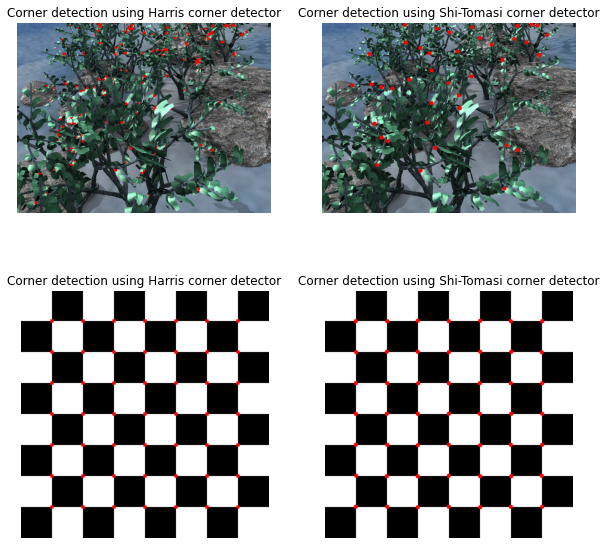

In [345]:
k = 0.04
window_size = 7
threshold_ratio = 0.25

img_path_chess = "chessboard_HCD.jpeg"
img_path_rubiks = "rubiks_HCD.jpeg"
img_path_grove = 'eval-data/Grove/frame10.png'

fig = plt.figure(figsize=(10, 10))


### Grove

input_img_grove = cv2.imread(img_path_grove)

fig.add_subplot(2, 2, 1)
corner_list_grove_harris, output_image_grove_harris = find_harris_corners(input_img_grove, k, window_size)

plt.imshow(output_image_grove_harris)
plt.axis('off')
plt.title("Corner detection using Harris corner detector")


separation_grove = 15
numPoints_grove = 40

fig.add_subplot(2, 2, 2)
corner_list_grove_shi, output_image_grove_shiTomasi = shi_tomashi(input_img_grove, window_size, numPoints_grove, separation_grove)

plt.imshow(output_image_grove_shiTomasi)
plt.axis('off')
plt.title("Corner detection using Shi-Tomasi corner detector")



### Chess

input_img_chess = cv2.imread(img_path_chess)

fig.add_subplot(2, 2, 3)
corner_list_chess_harris, output_image_chess_harris = find_harris_corners(input_img_chess, k, window_size)

plt.imshow(output_image_chess_harris)
plt.axis('off')
plt.title("Corner detection using Harris corner detector")


window_size = 3
separation_chess = 50
numPoints_chess = 49

fig.add_subplot(2, 2, 4)
#plt.imshow(input_img_chess)
corner_list_chess_shi, output_image_chess_shiTomasi = shi_tomashi(input_img_chess, window_size, numPoints_chess, separation_chess)

plt.imshow(output_image_chess_shiTomasi)
plt.axis('off')
plt.title("Corner detection using Shi-Tomasi corner detector")




I have applied `non maximal suppression` for Shi-Tomasi corner detector since the inbuilt function `goodfeaturestotrack` also has the same functionality. The major difference between the two methods is the score on which they rely on. The harris corner detector relies on the harris corner response score whereas Shi-Tomasi only considers the $\lambda_{min}$ as it's score. Also, for Shi-Tomasi the best $N$ score value points are taken whereas Harris corner detector takes all the points greater than the threshold value.

#### 2.2 Forward-Additive Sparse Optical Flow

In [417]:

def normalize_image(image):
    image = (image - np.mean(image)) /255
    
    return image

def isValid(A, threshold = 0.02):
    values, _ = np.linalg.eig(A)
    if min(values[0], values[1]) < threshold:
        return False
    return True

def plot_flow_image(image, u, v, arrowColor = 'black'):

    plt.imshow(image, 'gray')
    num_i, num_j = 16, 25

    for i in range(0, u.shape[0], int(u.shape[0]/num_i)):
        for j in range(0, u.shape[1], int(u.shape[1]/num_j)):
            ##plt.quiver(j, i, u[i, j], v[i, j], scale = 10, color = arrowColor)
            plt.quiver(j, i, u[i, j], v[i, j], scale = 10, color = arrowColor)
            #plt.quiver(j, i, u[i, j]/u.shape[1], v[i, j]/u.shape[0], scale = 0.03, color = arrowColor)

def plot_flow_multiple(image, u, v, numLevels, fig, position, arrowColor = 'red', scaleValue = 0.1):

    fig.add_subplot(int(np.ceil((numLevels + 1)/2.0)), 2, position)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Level: " + str(numLevels - position + 2))
    num_i, num_j = 16, 25

    for i in range(0, u.shape[0], int(u.shape[0]/num_i)):
        for j in range(0, u.shape[1], int(u.shape[1]/num_j)):
            #plt.quiver(j, i, u[i, j], v[i, j], scale = 10, color = arrowColor)
            plt.quiver(j, i, u[i, j]/u.shape[1], v[i, j]/u.shape[0], scale = scaleValue, color = arrowColor)

def plot_flow_for_video(image, u, v, frame_num, title = 'Optical flow for grove frame ', arrowColor = 'red', scaleValue = 10):

    plt.imshow(image)
    plt.axis('off')
    plt.title(title + str(frame_num))
    num_i, num_j = 16, 25

    for i in range(0, u.shape[0], int(u.shape[0]/num_i)):
        for j in range(0, u.shape[1], int(u.shape[1]/num_j)):
            plt.quiver(j, i, u[i, j], v[i, j], scale = scaleValue, color = arrowColor)

def normalConvolution(matrix, kernel):
    out = cv2.filter2D(matrix, -1, kernel)
    return out[(kernel.shape[0] - 1):, (kernel.shape[1] - 1):]


def LukasKanadeForwardAdditive(Img1, Img2, windowSize):

    windowWidth, windowHeight = windowSize
    wW, wH = int(windowWidth/2), int(windowHeight/2)
    
    #oldframe = cv2.imread(Img1)
    I1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
    I1 = normalize_image(I1)

    #newframe = cv2.imread(Img2)
    I2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
    I2 = normalize_image(I2)

    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    Ix = cv2.filter2D(I1, -1, kernel_x)
    Iy = cv2.filter2D(I1, -1, kernel_y)
    It = I2 - I1

    Ix_summation = convolve2d(Ix * Ix, np.ones(windowSize), mode = "valid")
    Iy_summation = convolve2d(Iy * Iy, np.ones(windowSize), mode = "valid")
    Ixy_summation = convolve2d(Ix * Iy, np.ones(windowSize), mode = "valid")
    Ixt_summation = convolve2d(Ix * It, np.ones(windowSize), mode = "valid")
    Iyt_summation = convolve2d(Iy * It, np.ones(windowSize), mode = "valid")
    

    A = np.ones((2, 2))
    B = np.ones((2, 1))
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)

    for i in range(wH, I1.shape[0] - wH):
        for j in range(wW, I1.shape[1] - wW):

            A[0, 0] = Ix_summation[i - wH, j - wW]
            A[1, 1] = Iy_summation[i - wH, j - wW]
            A[0, 1] = Ixy_summation[i - wH, j - wW]
            A[1, 0] = Ixy_summation[i - wH, j - wW]

            if isValid(A) == False:
                continue

            B[0, 0] = -Ixt_summation[i - wH, j - wW]
            B[1, 0] = -Iyt_summation[i - wH, j - wW]

            C = np.linalg.pinv(A) @ B

            u[i, j] = C[0, 0]
            v[i, j] = C[1, 0]
    
    return u, v

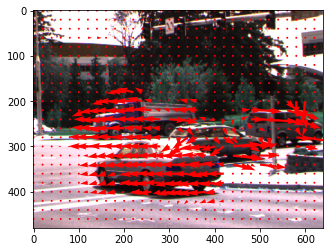

In [227]:

img1path = 'eval-data/Dumptruck/frame10.png'
img2path = 'eval-data/Dumptruck/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (41, 41)
u, v = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
plot_flow_image(image_1, u, v, 'red')
    

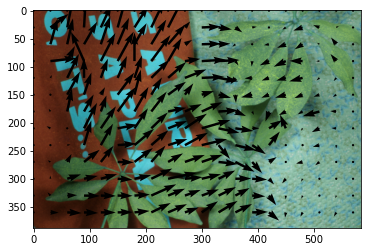

In [62]:
img1path = 'eval-data/Schefflera/frame10.png'
img2path = 'eval-data/Schefflera/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (41, 41)#(41, 41)
u, v = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
plot_flow_image(image_1, u, v)

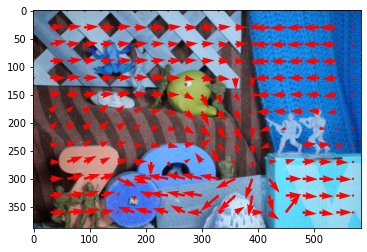

In [61]:
img1path = 'eval-data/Army/frame10.png'
img2path = 'eval-data/Army/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (41, 41)#(41, 41)
u, v = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
plot_flow_image(image_1, u, v, 'red')

In [378]:
def updateUV(u, v, NewShape):

    uNew = np.zeros(NewShape)
    vNew = np.zeros(NewShape)
    print("u's shape:", u.shape, "uNew's shape", uNew.shape)

    for i in range(2 * u.shape[0]):
        for j in range(2 * u.shape[1]):
            uNew[i, j] = u[int(i/2), int(j/2)] * 2
            vNew[i, j] = v[int(i/2), int(j/2)] * 2

    return uNew, vNew

def OpticalFlowRefine(Img1, Img2, windowSize, u0, v0):

    windowWidth, windowHeight = windowSize
    wW, wH = int(windowWidth/2), int(windowHeight/2)
    # timeGap = 1
    
    I1 = cv2.cvtColor(Img1, cv2.COLOR_BGR2GRAY)
    I1 = normalize_image(I1)

    I2 = cv2.cvtColor(Img2, cv2.COLOR_BGR2GRAY)
    I2 = normalize_image(I2)

    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    Ix = cv2.filter2D(I1, -1, kernel_x)
    Iy = cv2.filter2D(I1, -1, kernel_y)


    Ix_summation = convolve2d(Ix * Ix, np.ones(windowSize), mode = "valid")
    Iy_summation = convolve2d(Iy * Iy, np.ones(windowSize), mode = "valid")
    Ixy_summation = convolve2d(Ix * Iy, np.ones(windowSize), mode = "valid")

    Ixt1_summation = convolve2d(Ix * I1, np.ones(windowSize), mode = "valid")
    Iyt1_summation = convolve2d(Iy * I1, np.ones(windowSize), mode = "valid")

    Ixt2_summation = convolve2d(Ix * I2, np.ones(windowSize), mode = "valid")
    Iyt2_summation = convolve2d(Iy * I2, np.ones(windowSize), mode = "valid")

    A = np.zeros((2, 2))
    B = np.zeros((2, 2))

    u = u0.copy()
    v = v0.copy()

    for i in range(wH, I1.shape[0] - wH):
        for j in range(wW, I1.shape[1] - wW):

            start_i, start_j = i - wH, j - wW
            
            A[0, 0] = Ix_summation[i - wH, j - wW]
            A[1, 1] = Iy_summation[i - wH, j - wW]
            A[0, 1] = Ixy_summation[i - wH, j - wW]
            A[1, 0] = Ixy_summation[i - wH, j - wW]

            if isValid(A) == False:
                u[i, j], v[i, j] = 0, 0
                continue

            shift_i, shift_j = 0, 0

            if int(v[i, j]) + start_i >= 0 and int(v[i, j]) + start_i + windowHeight < I2.shape[0] and int(u[i, j]) + start_j >= 0 and int(u[i, j]) + start_j + windowWidth < I2.shape[1]:
                shift_i, shift_j = int(v[i, j]), int(u[i, j])
        
            B[0, 0] = -(Ixt2_summation[start_i + shift_i, start_j + shift_j] - Ixt1_summation[start_i, start_j])
            B[1, 0] = -(Iyt2_summation[start_i + shift_i, start_j + shift_j] - Iyt1_summation[start_i, start_j])

            C = np.linalg.pinv(A) @ B

            u[i, j] = shift_j + C[0, 0]
            v[i, j] = shift_i + C[1, 0]
            #print("i = ", i, "j = ", j)
    
    print("Optical flow succefully calculated for image:", u.shape)
    return u, v
    

def MultiScaleLucasKanade(Img1, Img2, windowSize, numLevels, scaleValue = 0.15, plot = True):

    if min(Img1.shape[0], Img1.shape[1]) < np.power(2, numLevels):
        print("numLevels is too large!")
        return 0

    fig = plt.figure(figsize=(10, 10))

    # Img1_set[i] represents Img1 after i levels of scaling.
    Img1_copy = Img1.copy()
    Img2_copy = Img2.copy()

    Img1_set = [Img1_copy]
    Img2_set = [Img2_copy]

    for i in range(numLevels):

        Img1_blur = cv2.blur(Img1_copy,(10,10))
        Img1_copy = cv2.resize(Img1_blur, (0, 0), fx=0.5, fy=0.5)
        Img2_blur = cv2.blur(Img2_copy,(10,10))
        Img2_copy = cv2.resize(Img2_blur, (0, 0), fx=0.5, fy=0.5)

        Img1_set.append(Img1_copy)
        Img2_set.append(Img2_copy)
    

    u = np.zeros(Img1_set[numLevels].shape[:2])
    v = np.zeros(Img1_set[numLevels].shape[:2])
    print("The lowest resolution image size is:", u.shape)

    for level in reversed(range(numLevels + 1)):

        oldframe = Img1_set[level]
        newframe = Img2_set[level]

        if level != numLevels:
            u, v = updateUV(u, v, newframe.shape[:2])

        u, v = OpticalFlowRefine(oldframe, newframe, windowSize, u, v)
        if plot == True:
            plot_flow_multiple(oldframe, u, v, numLevels, fig, numLevels - level + 1, scaleValue=scaleValue)
    
    return u, v


The lowest resolution image size is: (60, 80)
Optical flow succefully calculated for image: (60, 80)
u's shape: (60, 80) uNew's shape (120, 160)
Optical flow succefully calculated for image: (120, 160)
u's shape: (120, 160) uNew's shape (240, 320)
Optical flow succefully calculated for image: (240, 320)
u's shape: (240, 320) uNew's shape (480, 640)
Optical flow succefully calculated for image: (480, 640)


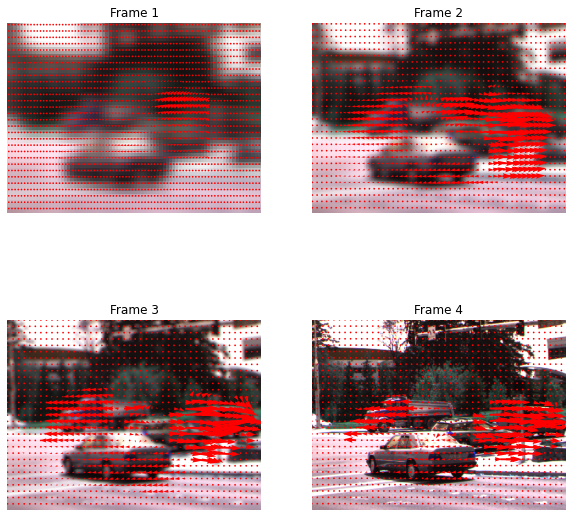

In [229]:
img1path = 'eval-data/Dumptruck/frame10.png'
img2path = 'eval-data/Dumptruck/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (35, 35)

u, v = MultiScaleLucasKanade(image_1, image_2, filter_size, 3)
#plot_flow_image(image_1, u, v)

The above plots display the outputs of the Multiscale Lucas Kanade at each level.

The lowest resolution image size is: (60, 80)
Optical flow succefully calculated for image: (60, 80)
u's shape: (60, 80) uNew's shape (120, 160)
Optical flow succefully calculated for image: (120, 160)
u's shape: (120, 160) uNew's shape (240, 320)
Optical flow succefully calculated for image: (240, 320)
u's shape: (240, 320) uNew's shape (480, 640)
Optical flow succefully calculated for image: (480, 640)


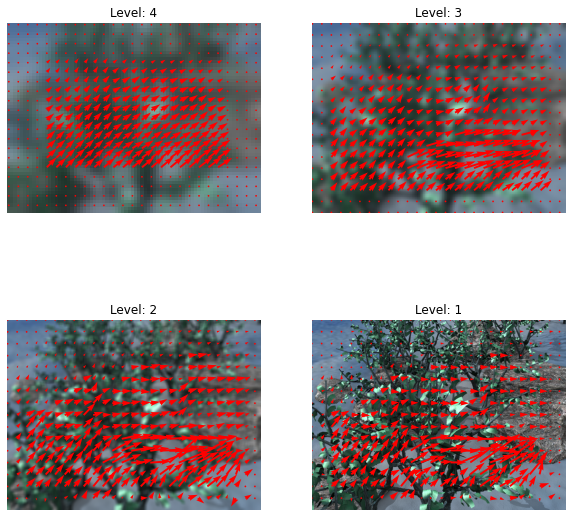

In [374]:
img1path = 'eval-data/Grove/frame10.png'
img2path = 'eval-data/Grove/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (25, 25)

u, v = MultiScaleLucasKanade(image_1, image_2, filter_size, 3, scaleValue=0.15)
#plot_flow_image(image_1, u, v)


The optical flow follows the visual perception which is that of top-right motion.

The lowest resolution image size is: (60, 80)
Optical flow succefully calculated for image: (60, 80)
u's shape: (60, 80) uNew's shape (120, 160)
Optical flow succefully calculated for image: (120, 160)
u's shape: (120, 160) uNew's shape (240, 320)
Optical flow succefully calculated for image: (240, 320)
u's shape: (240, 320) uNew's shape (480, 640)
Optical flow succefully calculated for image: (480, 640)


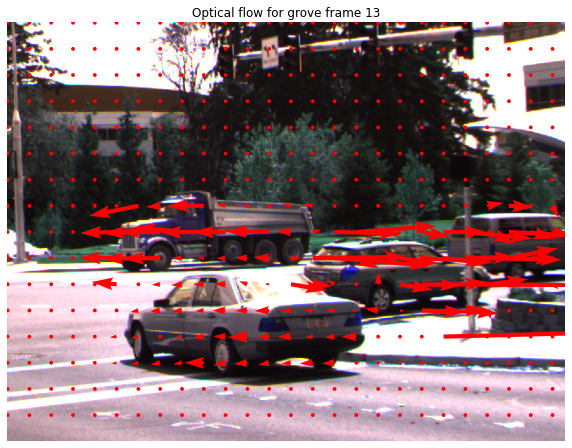

In [411]:
img1path = 'eval-data/Dumptruck/frame13.png'
img2path = 'eval-data/Dumptruck/frame14.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (25, 25)

u, v = MultiScaleLucasKanade(image_1, image_2, filter_size, 3, scaleValue = 0.25, plot=False)
plot_flow_for_video(image_1, u, v, frame_num = 13, scaleValue = 25)


The above photo gives a closer look into the optical flow vectors of each pixel. The car on the left is moving with the slowest velocity and its actually very difficult to notice its displacement from naked eye. The rightmost car is moving with the most velocity and hence has the longest quiver arrows.

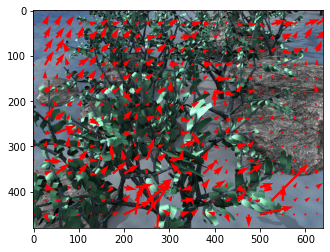

In [423]:
img1path = 'eval-data/Grove/frame10.png'
img2path = 'eval-data/Grove/frame12.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (25, 25)

u, v = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
plot_flow_image(image_1, u, v, 'red')


The lowest resolution image size is: (60, 80)
Optical flow succefully calculated for image: (60, 80)
u's shape: (60, 80) uNew's shape (120, 160)
Optical flow succefully calculated for image: (120, 160)
u's shape: (120, 160) uNew's shape (240, 320)
Optical flow succefully calculated for image: (240, 320)
u's shape: (240, 320) uNew's shape (480, 640)
Optical flow succefully calculated for image: (480, 640)


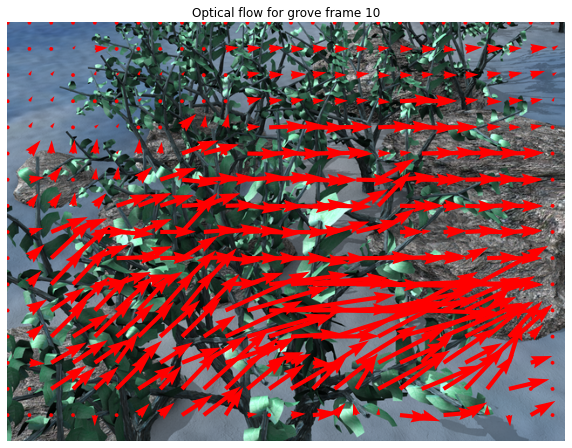

In [422]:
img1path = 'eval-data/Grove/frame10.png'
img2path = 'eval-data/Grove/frame12.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (25, 25)

u, v = MultiScaleLucasKanade(image_1, image_2, filter_size, 3, scaleValue = 0.25, plot=False)
plot_flow_for_video(image_1, u, v, frame_num = 10, scaleValue = 50)


#### Compare against part two and analyze the results. Show a case where multi-scale performs better than single-scale

The multiscale becomes even more efficient when more translation has occured, that's why I've compared grove fram 10 to grove frame 12, where mutli scale LK's results are much better than that of single scale LK. The plots are given above.

The lowest resolution image size is: (60, 80)
Optical flow succefully calculated for image: (60, 80)
u's shape: (60, 80) uNew's shape (120, 160)
Optical flow succefully calculated for image: (120, 160)
u's shape: (120, 160) uNew's shape (240, 320)
Optical flow succefully calculated for image: (240, 320)
u's shape: (240, 320) uNew's shape (480, 640)
Optical flow succefully calculated for image: (480, 640)


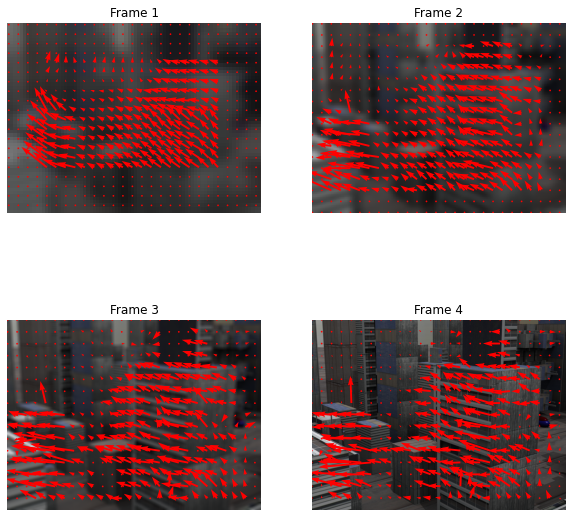

In [247]:
img1path = 'eval-data/Urban/frame10.png'
img2path = 'eval-data/Urban/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (25, 25)

u, v = MultiScaleLucasKanade(image_1, image_2, filter_size, 3)
#plot_flow_image(image_1, u, v)


Clearly the even the larger displacements (for example the closest building) are captured in the Multi-scale Lucas Kanade.

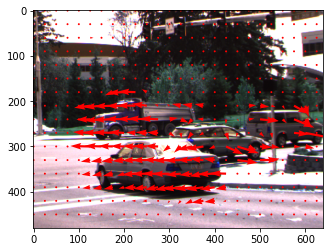

In [361]:
img1path = 'eval-data/Dumptruck/frame10.png'
img2path = 'eval-data/Dumptruck/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (51, 51)

u, v = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
plot_flow_image(image_1, u, v, 'red')

### 2.3 Analyzing Lucas-Kanade Method
1. Why is optical flow only valid in the regions where local structure-tensor $A^TA$ has a rank 2? What role does the threshold $\tau$ play here?  
<font color='green'>ANS: </font>Our main goal for optical flow is to find u and v. If $A^TA$ has rank less than 2 we will get infinite number of solutions for (u, v) which is why $A^TA$ has to be rank 2. Also, if $A^TA$ had rank less than 2, it would not be invertible which is required for deriving the soltuion for (u, v). The threshold $\tau$ ensures that the $\lambda_{min}$ is not too small which is also what we desire while applying harris corner detecctor. Thus, it ensures that the surfaces we are applying LK on has enough texture and is not an edge or a plane.  

2. In the experiments, did you use any modifications and/or thresholds? Does this algorithm work well for these test images? If not, why?  
<font color='green'>ANS: </font>Instead of mapping to $[0, 1]$ I mapped the image intensities to $[-1, 1]$ which gave better results. The LK algorithm doesn't generalise well, i.e., when the movement of an object is large it fails to detect it properly because of the smaller window size, this is where the multiscale LK comes to rescue. As for images which had comparable translations of objects, it worked pretty well.  

3. Try experimenting with different window sizes. What are the trade-offs associated with using a small versus a large window size? Can you explain what’s happening?  
<font color='green'>ANS: </font>Small window size is more sensitive to noise because the solution depends merely on say 9 pixels which can very easily contain randomness. Small window sizes can also very easily miss large motion displacement when single scale Lucas Kanade is used. Whereas large window sizes are more likely to cross an occlusion boundary and are prone to be slower because of more number of computations due to increased patch size.  
4. There are locations in an image where Lucas–Kanade optical flow will fail, regardless of choice of window size and sigma for Gaussian smoothing. Describe two such situations.You are not required to demonstrate them.  
<font color='green'>ANS: </font> Scenario 1 <font color='red'>(SMOOTH REGIONS) </font>- When the surface is planar without any texture, the light would be uniformly spread on the surface and the LK algorithm would not be able to distinguish the difference between any two frames.  
</font> Scenario 2 <font color='red'>(EDGES/APERTURE PROBLEM) </font>- When the surface only has an edge, it is very hard to detect the component of its velocity perpendicular to the edge, due to the which it becomes impossible to predict its motion.

5. Did you observe that the ground truth visualizations are in HSV colour space? Try to reason it.  
<font color='green'>ANS: </font>HSV has H mapped from 0 to 360 degrees which can represent direction of vector (u, v) and S or V can be used to represent the magnitude |u, v|.

##### Quiver plots superimposed are on the images and a compilation of the frames for the dumptruck dataset in the form of a video is saved as `dumpVideo.api`.

In [412]:
import os
def convert_frames_to_video(input_path,output_path,fps):
    all_frames = []
    files = os.listdir(input_path)
    files.sort()
    for i in range(len(files)):
        filename = input_path + files[i]
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        all_frames.append(img)
    out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(all_frames)):
        out.write(all_frames[i])
    out.release()

frame_rates = [1]
input_path= './dv_/'

for fps in frame_rates:    
    output_path = 'dumpVideo.avi'
    convert_frames_to_video(input_path, output_path, fps)
    

##### Compute the Average End Point Error (EPE) for grove3 dataset

In [416]:
img1path = 'data/all-frames-colour/Grove3/frame10.png'
img2path = 'data/all-frames-colour/Grove3/frame11.png'

image_1 = cv2.imread(img1path)
image_2 = cv2.imread(img2path)
filter_size = (41, 41)

u_, v_ = LukasKanadeForwardAdditive(image_1, image_2, filter_size)
#plot_flow_image(image_1, u, v, 'red')

In [415]:
def read_flo_file(filename, memcached=False):
    """
    Read from Middlebury .flo file
    :param flow_file: name of the flow file
    :return: optical flow data in matrix
    """
    if memcached:
        filename = io.BytesIO(filename)
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)[0]
    data2d = None

    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)[0]
        h = np.fromfile(f, np.int32, count=1)[0]
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

ground_truth = read_flo_file("./data/ground-truth-flow/Grove3/flow10.flo")

EPE = []

for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        tmp=[u_[i,j],v_[i,j]]
        EPE.append(np.linalg.norm(ground_truth[i,j]-tmp))

EPE=np.asarray(EPE)
print("EPE error is :",EPE.mean())

EPE error is : 3.724828845613407


Clearly the error is very low.

----